# Instability of parameter estimates

### Parameters

A parameter is anything that a model uses to constrain its predictions. Commonly, a parameter is a quantity that helps to describe a data set or a distribution. For example, the mean of a normal distribution is a parameter. In fact we say that a normal distribution is parametrized by its mean and variance. If we take the mean of a set of samples drawn from the normal distribution, we get an estimate of the mean of the distribution. Similarly, the mean of a set of observations is an estimate of the parameter of the underlying distribution (which is often assumed to be normal). Other parameters include the median, the correlation coefficient to another series, the standard deviation, and every other measurement of a data set.

### You never know, you only estimate

When you take the mean of a data set, you do not know the mean. We have estimated the mean as best as we can from the data we have. But the estimate can be off. This is actually true for any parameter we estimate. To actually understand what is going on, we need to determine how good our estimate is by looking at its stability/standard error/confidence intervals.

### Instability of estimates

Whenever we consider a set of observations, our calculation of a parameter can only be an estimate. It will change as we take more measurements or as time passes and we get new observations. We can quantify the uncertainty in our estimate by looking at how the parameter changes as we look at different subsets of the data. 

For instance, standard deviation describes how different the mean of a set is from the mean of each observation, that is, from each observation itself. In financial applications, data often comes in time series. In this case, we can estimate a parameter at different points in time. E.g. for the previous 30 days. By looking at how much this moving estimate fluctuates as we change our time window, we can compute the instability of the estimated parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use('bmh')

### Example: mean and standard deviation

First, let's take a look at some samples from a standard normal distribution. We know that the mean of the distribution is 0 and the standard deviation is 1. But if we measure the parameters from our observations, we will get only approximately 0 and approximately 1. 

-0.26951611032632805
0.027109073490359778
-0.020616059111720507
-0.038643973513210604


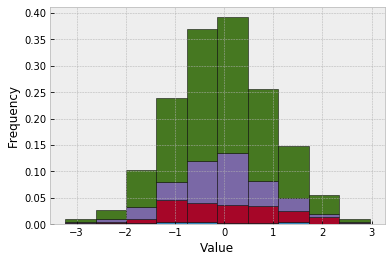

In [7]:
# set a seed so we can play with the data without generating
# new random numbers every time
np.random.seed(123)

normal = np.random.randn(500)
print(np.mean(normal[:10]))
print(np.mean(normal[:100]))
print(np.mean(normal[:250]))
print(np.mean(normal))

# plot a stacked histogram of the data
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], 
        normed=1, histtype='bar', stacked=True, edgecolor='black');
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.show();

In [8]:
print(np.std(normal[:10]))
print(np.std(normal[:100]))
print(np.std(normal[:250]))
print(np.std(normal))

1.236304801499023
1.128240470477961
1.0174604368340197
1.0032028561568238


We notice that although the probability of getting closer to 0 and 1 for the mean and standard deviation, respectively, increases with the number of samples, we do not always get better estimates by taking more data points. Whatever our expectation is, we can always get a different result and our goal is often to compute the probability that the result is significantly different than expected.

With time series data, we usually care only about contiguous subsets of the data. The moving average assigns the mean of the previous $n$ data points to each point in time. Below, we compute the 90-day moving average of a stock price and plot it to see how it changes. There is no result in the beginning because we first have to accumulate at least 90 days of data.

### Example: non-normal underlying distribution

What happens if the underlying data is not normal? A mean will be very deceptive. Because of this it's important to test for normality of your data. We'll use a Jarque-Bera test as an example.

mean: 0.10717932292042531
standard deviation: 5.0932179471204195


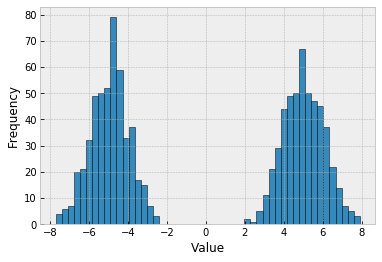

In [10]:
# generate some data from a bimodal distribution
def bimodal(n):
    X = np.zeros((n))
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] = np.random.normal(5, 1)
    return X

X = bimodal(1000)

plt.hist(X, bins=50, edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Value')
print('mean:', np.mean(X))
print('standard deviation:', np.std(X))
plt.show();

Sure enough, the mean is incredibly non-informative about what is going on in the data. We have collapsed all of our data into a single estimate, and lost a lot of information doing so. This is what the distribution should look like if our hypothesis that it is normally distributed is correct.

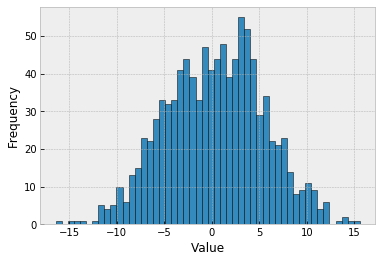

In [11]:
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.hist(N, bins=50, edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.show();

We can test our data using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.

In [12]:
from statsmodels.stats.stattools import jarque_bera

jarque_bera(X)

(141.76381019263675,
 1.6458102012062036e-31,
 -0.027942787918040154,
 1.1563058152077519)

The value is < 0.05 and we say that X is not normal. This saves us from accidentally making horrible predictions.

### Example: Sharpe ratio

One statistic often used to describe the performance of assets and portfolis is the Sharpe ratio which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills:

$$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}} $$

where $r_a$ is the returns on our asset and $r_b$ is the risk-free rate of return. As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how our estimate changes through time.

In [45]:
import pandas_datareader as pdr

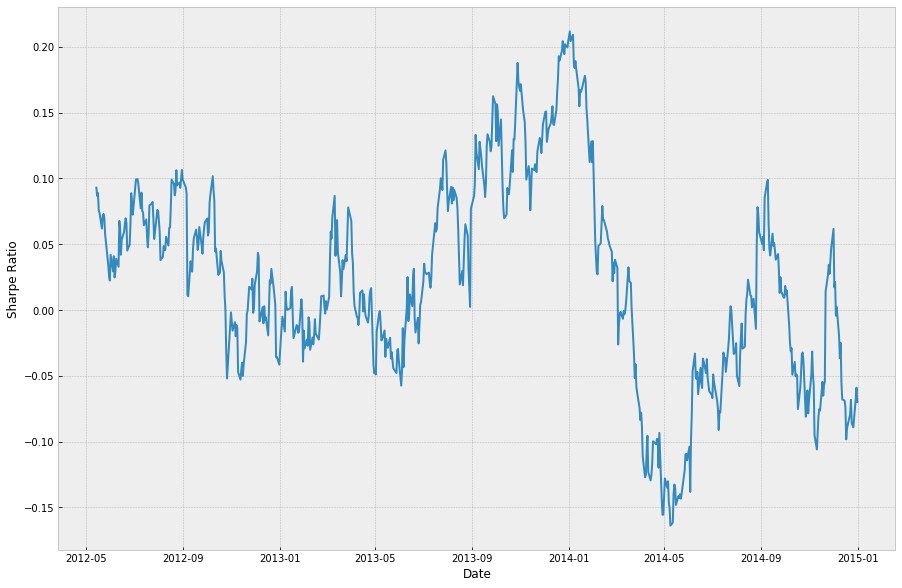

In [136]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

start = '2012-01-01'
end = '2015-01-01'
# use an index that tracks 13 week Treasury bill as our risk-free
# of return
treasury_ret = pdr.get_data_yahoo('^IRX', start=start, end=end)['Close'][1:].dropna()
pricing = pdr.get_data_yahoo('AMZN', start=start, end=end)['Close']
returns = pricing.pct_change()[1:]*100

running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]
df = pd.DataFrame(running_sharpe, index=returns.index[90:])

_, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(df);
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show();

The Sharpe ratio looks rather volatile, and it's clear that just reporting it as a single value will not be very helpful for predicting future values. Instead, we can compute the mean and standard deviation of the data above, and then see if it helps us predict the Sharpe ratio for the next 100 days.

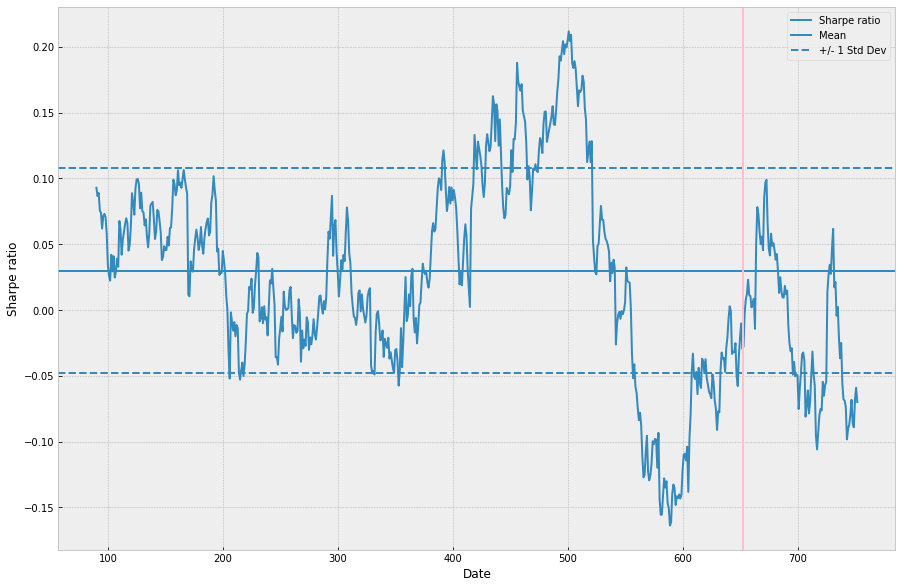

Mean of running Sharpe ratio: 0.030004371214112976
Std of running Sharpe ratio: 0.07762871921962086


In [139]:
# compute the mean and std of the running Sharpe ratios up to 
# 100 days before the end
mean_rs = np.mean(running_sharpe[:-100])
std_rs = np.std(running_sharpe[:-100])

# plot running Sharpe ratio
_, ax2 = plt.subplots(figsize=(15,10))
ax2.plot(range(90, len(returns)), df)

# plot its mean and the +/- 1 standard deviation lines
ax2.axhline(mean_rs)
ax2.axhline(mean_rs + std_rs, linestyle='--')
ax2.axhline(mean_rs - std_rs, linestyle='--')

# indicate where we computed the mean and standard deviations
# everything after this is 'out of sample' which we are comparing
# with the estimated mean and std
ax2.axvline(len(returns) - 100, color='pink');
plt.xlabel('Date')
plt.ylabel('Sharpe ratio')
plt.legend(['Sharpe ratio', 'Mean', '+/- 1 Std Dev'])
plt.show();

print('Mean of running Sharpe ratio:', mean_rs)
print('Std of running Sharpe ratio:', std_rs)

The standard deviation in this case is about a quarter of the range, so this data is extremely volatile. Taking this into account when looking ahead gave a better prediction that just using the mean, although we still observed data more than one std dev away. We could also compute the rolling mean of the Sharpe ratio to try and follow trend; but in that case, too, we should keep in mind the standard deviation.

### Example: moving average

Let's say you take the average with a lookback window; how would you determine the standard error on that estimate? Let's start with an example showing a 90-day moving average.

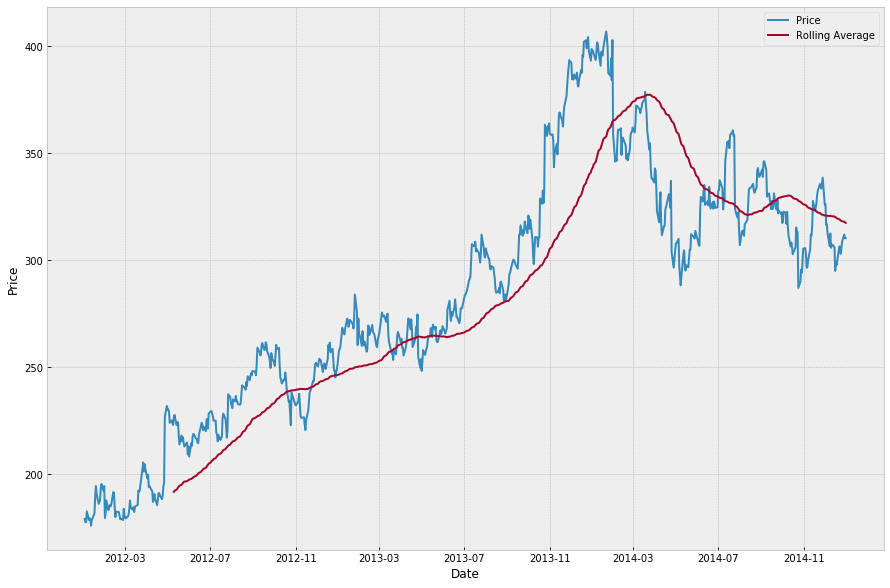

In [143]:
# compute the rolling mean for each day
mu = pricing.rolling(90).mean()

# plot pricing data
_, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(pricing)
plt.ylabel('Price')
plt.xlabel('Date')

# plot rolling mean
ax1.plot(mu);
plt.legend(['Price', 'Rolling Average'])
plt.show();

This lets us see the instability/standard error of the mean, and helps anticipate future variability in the data. We can quantify this variability by computing the mean and standard deviation of the rolling mean.

In [144]:
print('Mean of rolling mean:', np.mean(mu))
print('Std of rolling mean:', np.std(mu))

Mean of rolling mean: 288.3863395439601
Std of rolling mean: 51.135150263377945


In fact, the standard deviation, which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute its mean and standard deviation.

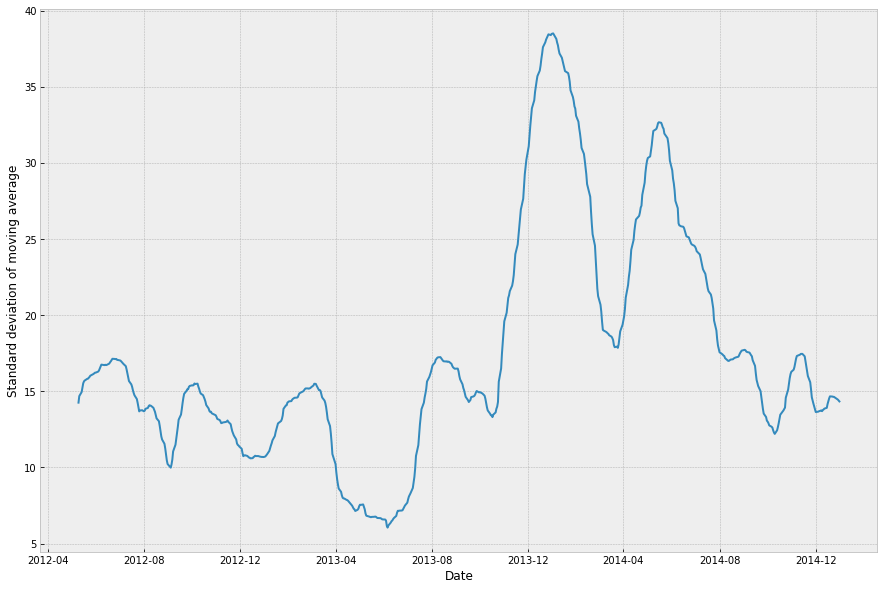

Mean of rolling std: 17.40382771898358
Std of rolling std: 7.544692090459442


In [145]:
# compute rolling std deviation
std = pricing.rolling(90).std()

# plot rolling std
_, ax2 = plt.subplots(figsize=(15,10))
ax2.plot(std)
plt.ylabel('Standard deviation of moving average')
plt.xlabel('Date')
plt.show();

print('Mean of rolling std:', np.mean(std))
print('Std of rolling std:', np.std(std))

To see what this changing standard deviation means for our data set, let's plot the data again along with the Bollinger bands: the rolling mean, one rolling standard deviation (of the data) above the mean and one standard deviation below.

Note that although standard deviations give us more information about the spread of the data, we cannot assign precise probabilities to our expectations for future observations without assuming a particular distribution for the underlying process.

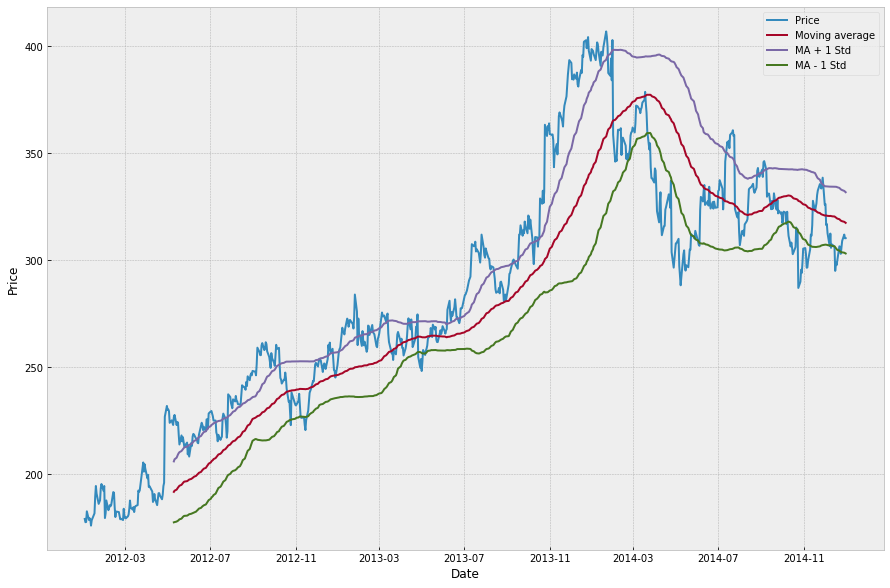

In [146]:
# plot original data
_, ax3 = plt.subplots(figsize=(15, 10))
ax3.plot(pricing)

# plot Bollinger bands
ax3.plot(mu)
ax3.plot(mu + std)
ax3.plot(mu - std)
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Price', 'Moving average', 'MA + 1 Std', 'MA - 1 Std'])
plt.show();

### Conclusion

Whenever we compute a parameter for a data set, we should also compute its volatility. Otherwise, we do not know whether or not we should expect new data points to be aligned with this parameter. A good way of computing volatility is dividing the data into subsets and estimating the parameter from each one, then finding the variability among the results. There may still be outside factors which are introduced after our sample period and which we cannot predict. However, the instability analysis and testing for standard error is still very useful for telling us how much we should distrust our estimates.